# Project 1: Image and Video Analysis
Ikram Ul Haq, Seyf Edine

In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data_path = "./data/"
label_file = "labels.csv"

## Data Analysis and Visualisation
#### Let's have a look on the all the Images

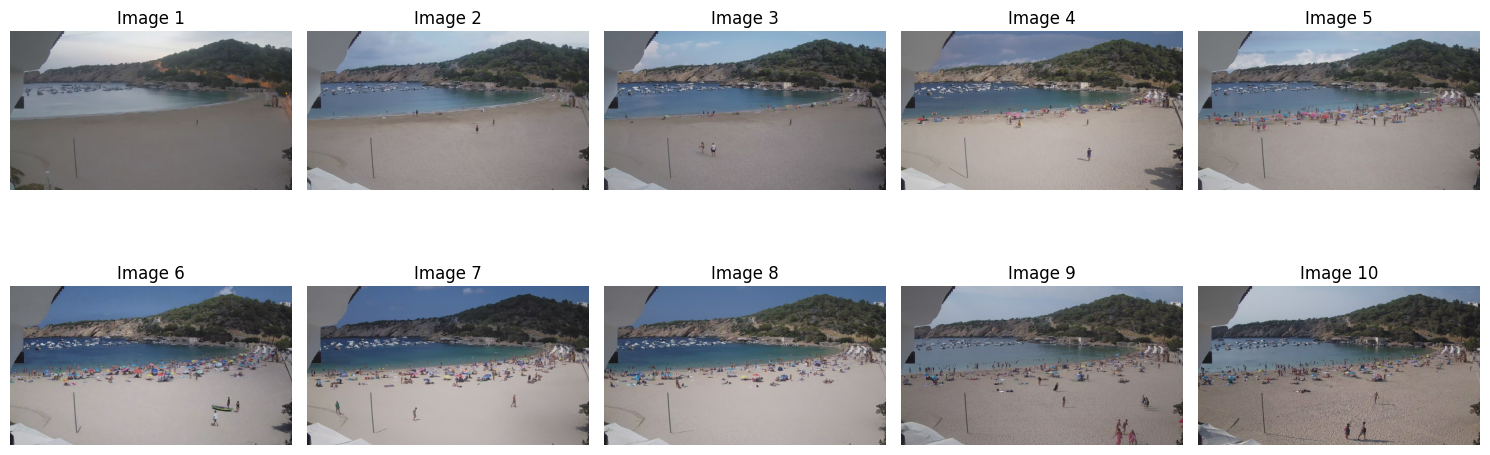

In [3]:
image_paths = [data_path + f'{i}.jpg' for i in range(0, 10)]

# Plot all images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    # Read image
    image_path = image_paths[i]
    image = cv2.imread(image_path)

    # Display the image
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Image {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()


#### These images were labeld manually and labels.csv contains all the labels for people in the image.

In [4]:
df = pd.read_csv(label_file)
df.head()

label     x    y image_name  size_x  size_y
0  Person  1157  654      1.jpg    1920    1080
1  Person   748  534      1.jpg    1920    1080
2  Person   723  541      1.jpg    1920    1080
3  Person  1061  504      1.jpg    1920    1080
4  Person   918  562      1.jpg    1920    1080

#### How many people are in each image

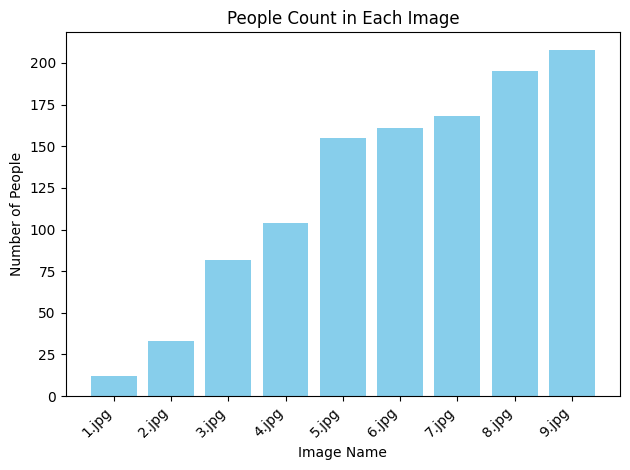

In [5]:
people_count = df.groupby('image_name')['label'].count()

# Plotting the bar chart
plt.bar(people_count.index, people_count.values, color='skyblue')
plt.xlabel('Image Name')
plt.ylabel('Number of People')
plt.title('People Count in Each Image')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

creating this result dataframe, it will contain all the information about the detection and Evaluation. one row per image.

In [6]:
result = pd.DataFrame()

#### Let's plot all the images with ground truths.

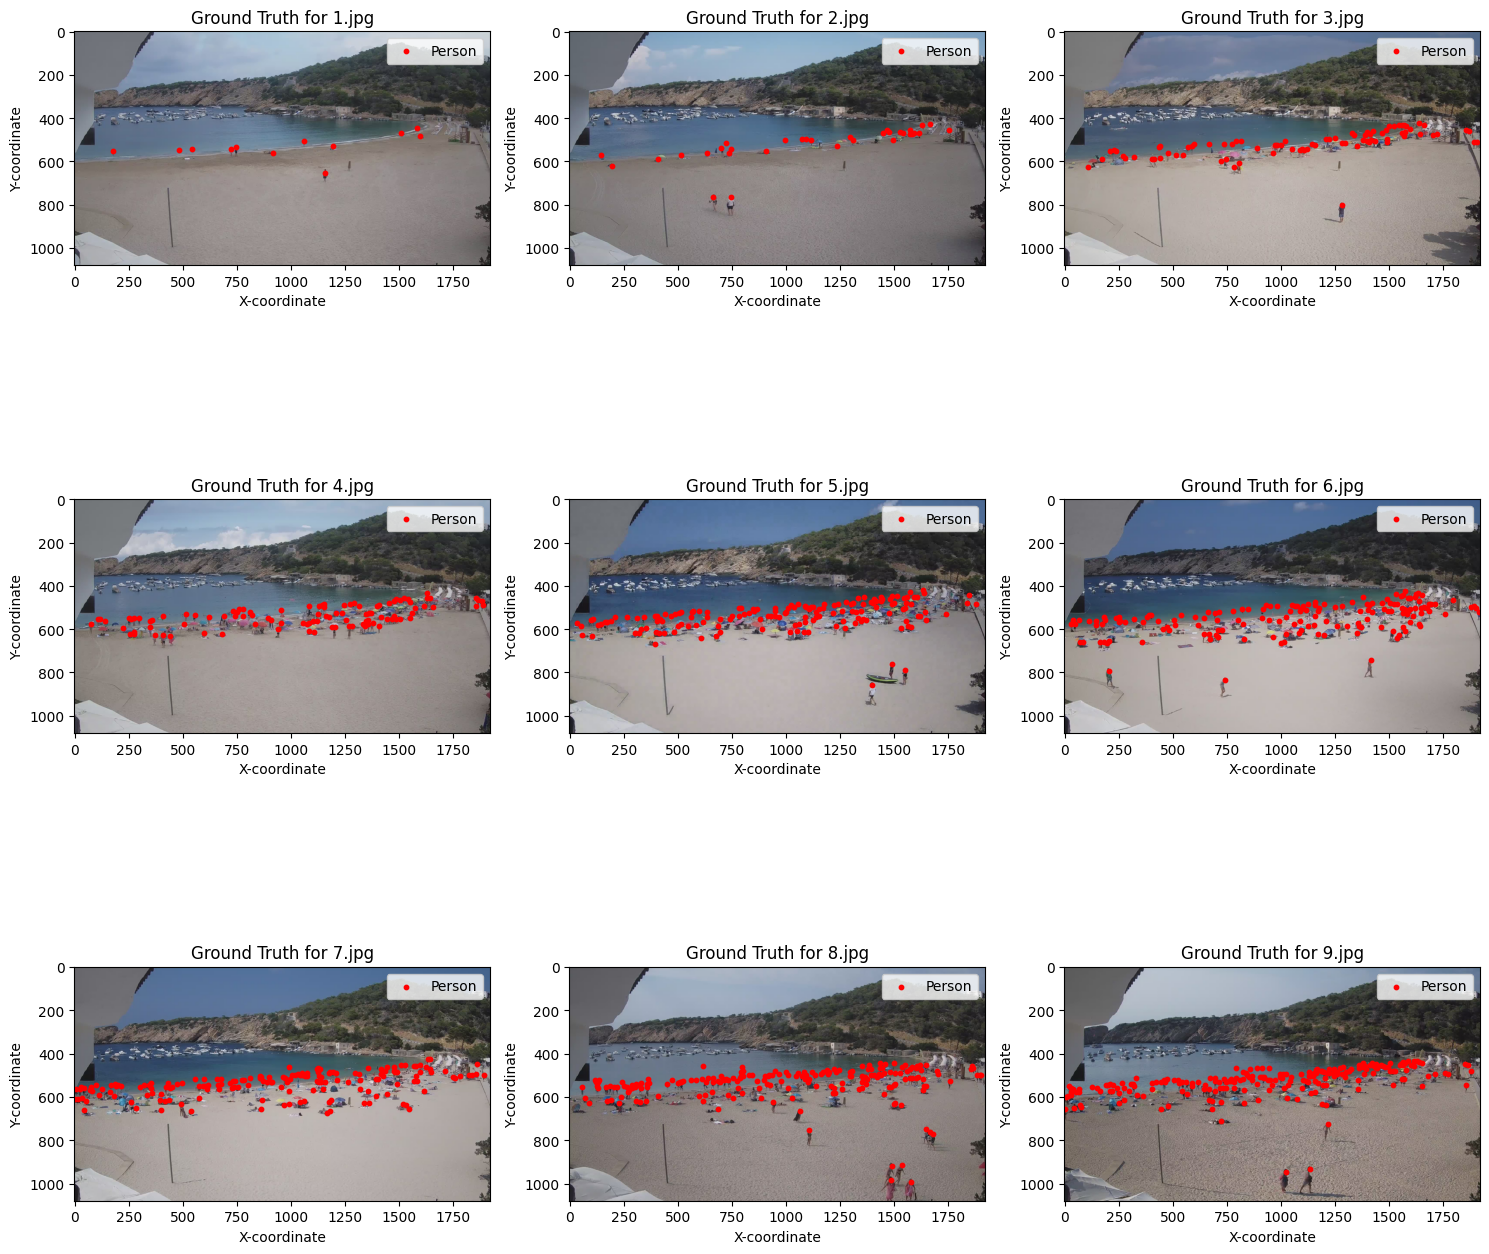

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
result['image'] = [f'{i}.jpg' for i in range(1, 10)]
ground_truths = []

# Loop through each image and draw points
for idx, image_name in enumerate(df['image_name'].unique()):
    image_data = df[df['image_name'] == image_name]
    ground_truths.append(len(image_data))

    image_path = data_path + image_name  # Replace with the actual path to your images
    image = cv2.imread(image_path)
    ax = axes[idx // 3, idx % 3]

    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.scatter(image_data['x'], image_data['y'], color='red', marker='o', label='Person', s=10)

    ax.set_title(f'Ground Truth for {image_name}')
    ax.set_xlabel('X-coordinate')
    ax.set_ylabel('Y-coordinate')
    ax.legend()

plt.tight_layout()
plt.show()

In [8]:
result['ground_truths'] = ground_truths

## Detection
Let's write some function that will help to process image before detection.

In [9]:
def read_image(image_path):
    """
    Read an image from the given path.
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image from {image_path}")
    return image

Shape of the image (1080, 1920, 3)


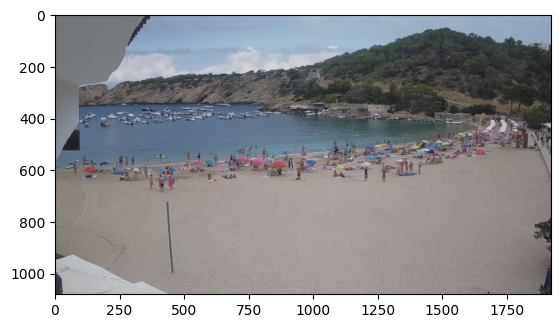

In [10]:
image_path = data_path + "4.jpg"
image = read_image(image_path)
print("Shape of the image", image.shape)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Conversion to greyscale
Conversion to greyscale for better contour formation

In [11]:
def convert_to_grayscale(image):
    """
    Convert an image to grayscale.
    """
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

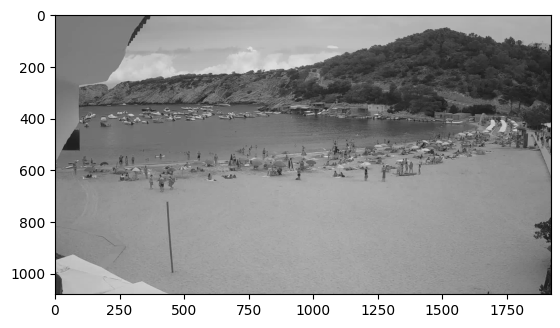

In [12]:
gs_image = convert_to_grayscale(image)
plt.imshow(gs_image, cmap='gray')

## Background Subtraction
We are aware that in the image "0.jpg" there are no people to detect so we can use that image as background to only get people. for background subtraction, we will first blur the image using 5x5 gaussina blur filter and then we will calculate the absolute difference and apply threshold to finally obtain a binary mask.

In [13]:
def apply_background_subtraction(image, background, threshold=25):
    """
    Apply background subtraction to obtain a binary mask.
    """
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    blurred_background = cv2.GaussianBlur(background, (5, 5), 0)

    # Compute the absolute difference between the two blurred images
    diff = cv2.absdiff(blurred_background, blurred_image)

    # Threshold the difference image to obtain a binary mask
    _, thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    return mask

Let's see an example of subtracting the background after converting the images to greyscale.

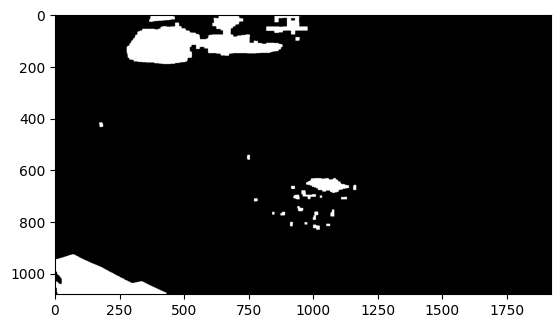

In [14]:
image = read_image(data_path + "1.jpg")
background = read_image(data_path + "0.jpg")

gray_image = convert_to_grayscale(image)
gray_background = convert_to_grayscale(background)

# Apply background subtraction
mask = apply_background_subtraction(gray_image, gray_background, threshold=40)

plt.imshow(mask, cmap='gray')

## Countour detection
In the following function, i have written the simple code to detect contours from a mask that we obtained after subtracting the background.

In [15]:
def find_people_contours(mask, min_contour_area=0, min_aspect_ratio=0.1):
    """
    Find contours in the binary mask and filter based on size and aspect ratio.
    Return a list of centroid coordinates for each detected person.
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    people_centroids = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > min_contour_area and cv2.arcLength(cnt, True) > min_aspect_ratio * area:
            # Calculate centroid of the contour
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                people_centroids.append((cx, cy))

    return people_centroids

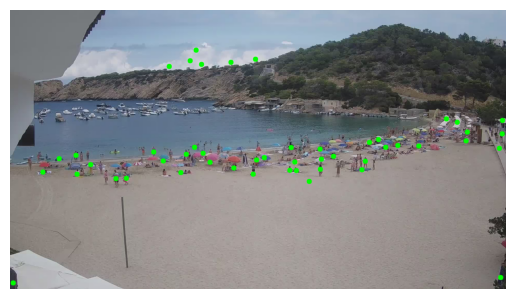

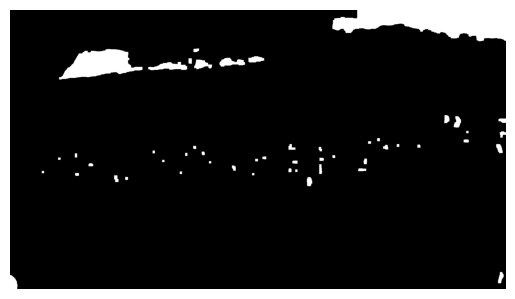

In [16]:
image_path = data_path + "4.jpg"

background_path = data_path + "1.jpg"
# background_path = data_path + "1.jpg"

image = read_image(image_path)
background = read_image(background_path)

if image is not None and background is not None:
    gray_image = convert_to_grayscale(image)
    gray_background = convert_to_grayscale(background)

    mask = apply_background_subtraction(gray_image, gray_background)
    
    people_centroids = find_people_contours(mask)
    result_image = image.copy()
    for cx, cy in people_centroids:
        cv2.circle(result_image, (cx, cy), 10, (0, 255, 0), -1)

    # Display the result image
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    plt.axis('off')


## Experiment on the whole dataset
Using the code in the above cell let's try detection on the whole dataset.

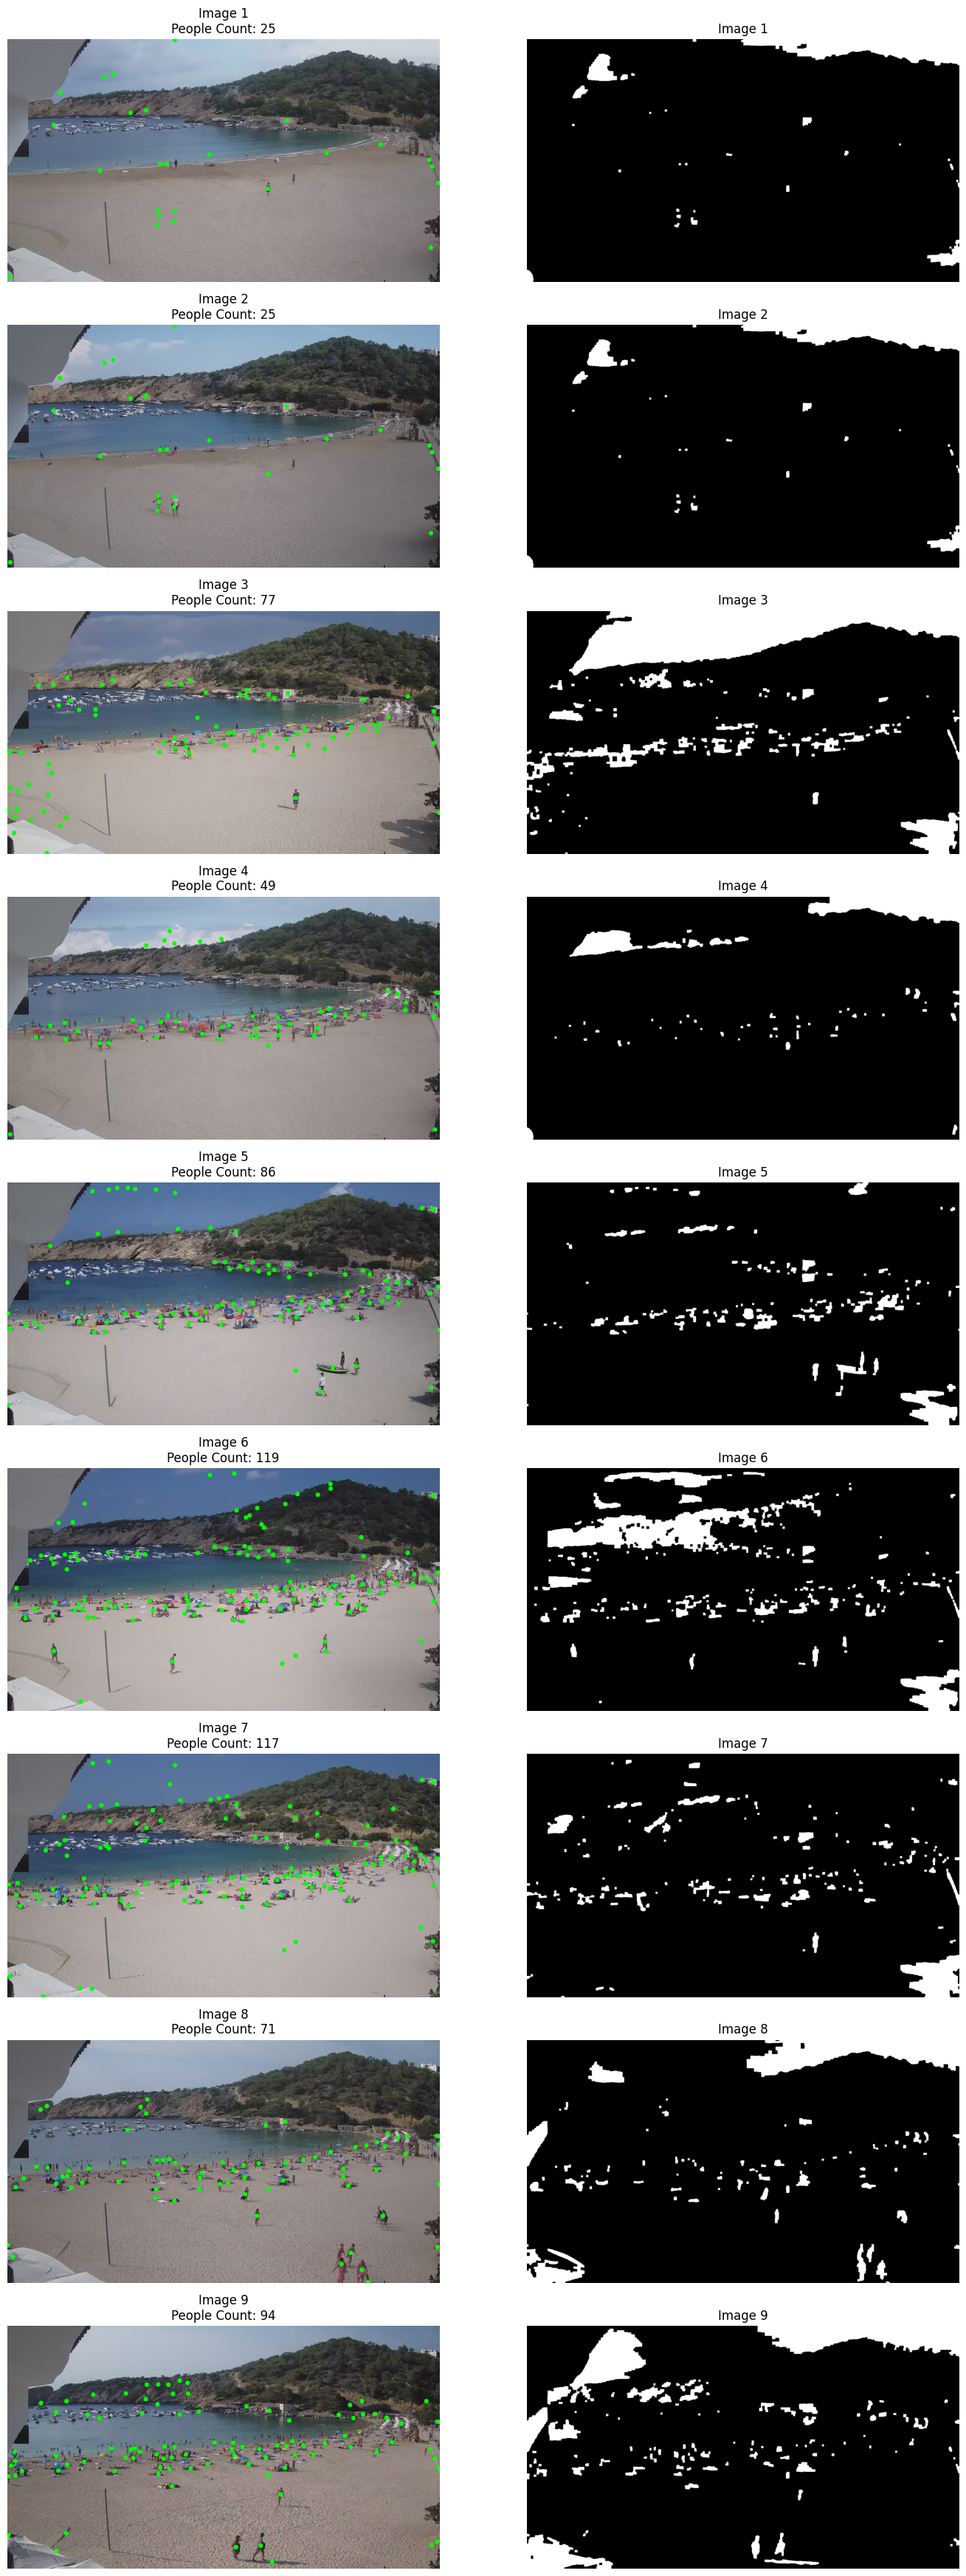

In [17]:
counts = []
all_people_centroids = []
image_paths = [data_path + f'{i}.jpg' for i in range(1, 10)]

fig, axes = plt.subplots(9, 2, figsize=(15, 35))

for i, ax in enumerate(axes):
    image_path = image_paths[i]

    background_path = data_path + {1: "2.jpg", 2: "1.jpg", 3: "4.jpg", 4: "1.jpg", 5: "3.jpg", 6: "3.jpg", 7: "3.jpg"}.get(i+1, "1.jpg")
    # background_path = data_path + "1.jpg"

    image = read_image(image_path)
    background = read_image(background_path)

    if image is not None and background is not None:
        # Convert images to grayscale
        gray_image = convert_to_grayscale(image)
        gray_background = convert_to_grayscale(background)

        # Apply background subtraction
        mask = apply_background_subtraction(gray_image, gray_background)
        
        # Find people centroids
        people_centroids = find_people_contours(mask)
        all_people_centroids.append(people_centroids)
        counts.append(len(people_centroids))

        # Draw centroids on the original image
        result_image = image.copy()
        for cx, cy in people_centroids:
            cv2.circle(result_image, (cx, cy), 10, (0, 255, 0), -1)

        # Display the result image
        ax[0].imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        ax[0].set_title(f"Image {i+1}\nPeople Count: {len(people_centroids)}")
        ax[0].axis('off')
        ax[1].imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
        ax[1].set_title(f"Image {i+1}")
        ax[1].axis('off')

plt.tight_layout()
plt.show()

## Evaluation

In [18]:
result['detected'] = counts
result

image  ground_truths  detected
0  1.jpg             12        25
1  2.jpg             33        25
2  3.jpg             82        77
3  4.jpg            104        49
4  5.jpg            155        86
5  6.jpg            161       119
6  7.jpg            168       117
7  8.jpg            195        71
8  9.jpg            208        94

In [19]:
result['mse'] = np.power(result['ground_truths'] - result['detected'], 2)
result

image  ground_truths  detected    mse
0  1.jpg             12        25    169
1  2.jpg             33        25     64
2  3.jpg             82        77     25
3  4.jpg            104        49   3025
4  5.jpg            155        86   4761
5  6.jpg            161       119   1764
6  7.jpg            168       117   2601
7  8.jpg            195        71  15376
8  9.jpg            208        94  12996

In [20]:
print(f"Mean MSE: {result['mse'].mean()}")

Mean MSE: 4531.222222222223


In [21]:
def calculate_distances(detected_positions, ground_truth_positions):
    distances = np.zeros((len(detected_positions), len(ground_truth_positions)))

    for i, det_pos in enumerate(detected_positions):
        for j, gt_pos in enumerate(ground_truth_positions):
            distances[i, j] = np.linalg.norm(np.array(det_pos) - np.array(gt_pos))

    return distances

In [22]:
def calculate_metrics(detected_positions, ground_truth_positions, distance_threshold):
    distances = calculate_distances(detected_positions, ground_truth_positions)

    # Initialize arrays to keep track of detection status
    detected_flags = np.zeros(len(detected_positions), dtype=bool)
    ground_truth_flags = np.zeros(len(ground_truth_positions), dtype=bool)

    # True positives (TP), False positives (FP), False negatives (FN)
    TP, FP, FN = 0, 0, 0

    for j in range(distances.shape[1]):
        min_distance_idx = np.argmin(distances[:, j])
        min_distance = distances[min_distance_idx, j]

        # If the minimum distance is less than the threshold, consider it a detection
        if min_distance < distance_threshold:
            detected_idx, ground_truth_idx = min_distance_idx, j

            # Check if the points have already been matched
            if not detected_flags[detected_idx] and not ground_truth_flags[ground_truth_idx]:
                TP += 1
                detected_flags[detected_idx] = True
                ground_truth_flags[ground_truth_idx] = True
            else:
                FP += 1

    # Calculate remaining unmatched ground truths as false negatives
    FN = np.sum(~ground_truth_flags & (distances.min(axis=0) >= distance_threshold))

    return TP, FP, FN


In [23]:
tps, fps, fns = [], [], []
images = [f'{i}.jpg' for i in range(1, 10)]

for index, image in enumerate(images):
    
    one_image = df[df['image_name'] == image]
    
    ground_truth_positions = list(zip(one_image['x'], one_image['y']))
    
    detected_positions = all_people_centroids[i]
    distance_threshold = 50
    
    TP, FP, FN = calculate_metrics(detected_positions, ground_truth_positions, distance_threshold)

    tps.append(TP)
    fps.append(FP)
    fns.append(FN)

In [24]:
result["TP"] = tps
result["FP"] = fps
result["FN"] = fns
result

image  ground_truths  detected    mse  TP  FP  FN
0  1.jpg             12        25    169   9   1   2
1  2.jpg             33        25     64  14   6  13
2  3.jpg             82        77     25  29  37  16
3  4.jpg            104        49   3025  32  43  29
4  5.jpg            155        86   4761  41  60  54
5  6.jpg            161       119   1764  42  65  54
6  7.jpg            168       117   2601  37  77  54
7  8.jpg            195        71  15376  38  71  86
8  9.jpg            208        94  12996  53  91  64

In [25]:
result['precision'] = result['TP'] / (result['TP'] + result['FP']).replace(0, 1)
result['recall'] = result['TP'] / (result['TP'] + result['FN']).replace(0, 1)
result['f1_score'] = 2 * (result['precision'] * result['recall']) / (result['precision'] + result['recall'])

result

image  ground_truths  detected    mse  TP  FP  FN  precision    recall  \
0  1.jpg             12        25    169   9   1   2   0.900000  0.818182   
1  2.jpg             33        25     64  14   6  13   0.700000  0.518519   
2  3.jpg             82        77     25  29  37  16   0.439394  0.644444   
3  4.jpg            104        49   3025  32  43  29   0.426667  0.524590   
4  5.jpg            155        86   4761  41  60  54   0.405941  0.431579   
5  6.jpg            161       119   1764  42  65  54   0.392523  0.437500   
6  7.jpg            168       117   2601  37  77  54   0.324561  0.406593   
7  8.jpg            195        71  15376  38  71  86   0.348624  0.306452   
8  9.jpg            208        94  12996  53  91  64   0.368056  0.452991   

   f1_score  
0  0.857143  
1  0.595745  
2  0.522523  
3  0.470588  
4  0.418367  
5  0.413793  
6  0.360976  
7  0.326180  
8  0.406130

In [26]:
print("Mean F1 Score:", result['f1_score'].mean())

Mean F1 Score: 0.48571609796263043
